In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import math
import os
import xlrd # for excel sheets


In [2]:
def list_files(dir):
    r = []
    direc = []
    for root, dirs, files in os.walk(dir):
        for name in files:
            r.append(os.path.join(root, name))
            if 'Results' in name:
                direc.append(name)
    return r, direc

In [3]:
def get_str (file):
    strength = 0
    with open(file) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        for row in csv_reader:
            line_count+=1
            if line_count == 8:
                strength = row[5]
    return strength

In [4]:
#Import max shear strength data
root_dirc = r'C:\Users\gowtham4\Box\DOE_HX\Data_experiments\Thermomechanical Testing\Epoxy_Sep20_to_Oct4_2019\Sinhalab_Epoxy_Shear_Tests'
r, direc = list_files(root_dirc)
types = ['CuK','CuCu'] # K is Kapton
adh_list = ['KW','CW','PB','CO']
temps = ['T1','T2','T3']
reps =['_1','_2','_3','_4','_5'] # repetitions

CuK_shear_str = np.zeros((len(adh_list),len(temps),len(reps))) # 4 adh x (3 temps x 5 reps)
CuCu_shear_str = np.zeros((len(adh_list),len(temps),len(reps))) # 4 adh x (3 temps x 5 reps)

for i in range(np.size(r)):
    if 'Results' in r[i]:
        shear_str = get_str(r[i])

        for sample in types:
            if sample in r[i]:
                a = types.index(sample)             
                for adh in adh_list:
                    if adh in r[i]:
                        b = adh_list.index(adh)
                        for T in temps:
                            if T in r[i]:
                                c = temps.index(T)
                                for rep in reps:
                                    if T+rep in r[i]:
                                        d = reps.index(rep)
                                        break                               
                                break
                        break
                break
 
        # assign value in array   

        if a == 0:
            CuK_shear_str[b][c][d] = round(float(shear_str),2)
        if a == 1:
            CuCu_shear_str[b][c][d] = round(float(shear_str),2)
    else: 
        continue
                       
# print(CuK_shear_str)
# print(CuCu_shear_str)

In [5]:
# temps
temps_file = r'C:\Users\gowtham4\Box\DOE_HX\Data_experiments\Thermomechanical Testing\Epoxy_Sep20_to_Oct4_2019\real_temperature.xlsx'

typess = ['Cu_K','Cu_Cu'] # K is Kapton

wb = xlrd.open_workbook(temps_file)

T2_temps = np.zeros((2, len(adh_list), 2, len(reps))) # CuK,CuCu x (4 adh x (Front,Back x 5 reps))
T3_temps = np.zeros((2, len(adh_list), 2, len(reps)))

sheet_lst = wb.sheet_names()

for sht in sheet_lst:
    sheet = wb.sheet_by_name(sht)  
    for t in typess:
        if t in sht:
            a = typess.index(t)
            for adh in adh_list:
                if adh in sht:
                    b = adh_list.index(adh)
                    for m in range(2):
                        for n in range(len(reps)):
                            T2_temps[a,b,m,n] = sheet.cell_value(1+n,2+m) # look at the real_temperature excel 
                            T3_temps[a,b,m,n] = sheet.cell_value(7+n,2+m)
                    break
            break       
        
#print (T2_temps,'\n\n', T3_temps)

#print(sheet_lst)

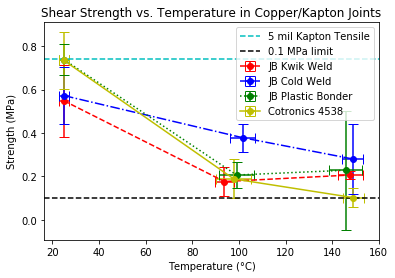

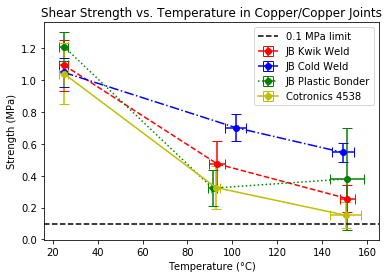

In [10]:
## Plotting Results

clrs = ['r','b','g','y']
linsty = ['--', '-.', ':', '-']
adh_names = ["JB Kwik Weld","JB Cold Weld", "JB Plastic Bonder", "Cotronics 4538"]

### Copper/ Kapton Joints ###

for i in range(4):
    # plt.plot(range(3),np.mean(CuK_shear_str[i][:][:],axis = 1), clrs[i], marker ='o',label = adh_list[i], linestyle = linsty[i])
    x_means = np.array([25,np.mean(T2_temps[0][i][:][:],axis = 1)[0],np.mean(T3_temps[0][i][:][:],axis = 1)[0]])
    x_errs = np.array([2,0.5*(np.max(T2_temps[0][i][:][:],axis = 1)[0]-np.min(T2_temps[0][i][:][:],axis = 1)[0]),0.5*(np.max(T3_temps[0][i][:][:],axis = 1)[0]-np.min(T3_temps[0][i][:][:],axis = 1)[0])])
    y_means = np.mean(CuK_shear_str[i][:][:],axis = 1)
    
    # range based error bar
    y_errs = np.array([0.5*(np.max(CuK_shear_str[i][j][:])- np.min(CuK_shear_str[i][j][:])) for j in range(len(temps))]) 
    
    # minmax based error bar
#     y_errs = np.asarray([np.min(CuK_shear_str[i][j][:]) for j in range(len(temps))])
#     y_errs = np.append(y_errs,np.asarray([np.max(CuK_shear_str[i][j][:]) for j in range(len(temps))]),axis =0)
#     y_errs = np.array(y_errs).reshape(2,len(temps))
    plt.errorbar(x_means,y_means,yerr = y_errs, xerr = x_errs,linestyle = linsty[i], fmt ='-o'+clrs[i],ecolor= clrs[i], 
                 mfc = clrs[i], capsize= 5, label = adh_names[i])  
    
plt.axhline(y=0.74, color='c', linestyle='--', label = '5 mil Kapton Tensile')
plt.axhline(y=0.1, color='k', linestyle='--', label = '0.1 MPa limit')
plt.title("Shear Strength vs. Temperature in Copper/Kapton Joints")
plt.xlabel("Temperature (°C)")
plt.ylabel("Strength (MPa)")
plt.legend()    
fname = r'C:\Users\gowtham4\Box\DOE_HX\Data_experiments\Thermomechanical Testing\Epoxy_Sep20_to_Oct4_2019\\'+ 'CuK_Shear_Results'+'.jpg'
plt.savefig(fname, format = 'jpg', dpi = 600 )
plt.show()


### Copper/ Copper Joints ###


for i in range(4):
    #plt.plot(range(3),np.mean(CuCu_shear_str[i][:][:],axis = 1), clrs[i], marker ='o', label = adh_list[i], linestyle = linsty[i])
    x_means = np.array([25,np.mean(T2_temps[1][i][:][:],axis = 1)[0],np.mean(T3_temps[1][i][:][:],axis = 1)[0]])
    x_errs = np.array([2,0.5*(np.max(T2_temps[1][i][:][:],axis = 1)[0]-np.min(T2_temps[1][i][:][:],axis = 1)[0]),0.5*(np.max(T3_temps[1][i][:][:],axis = 1)[0]-np.min(T3_temps[1][i][:][:],axis = 1)[0])])
    y_means = np.mean(CuCu_shear_str[i][:][:],axis = 1)
    
    # range based error bar
    y_errs = np.array([0.5*(np.max(CuCu_shear_str[i][j][:])- np.min(CuCu_shear_str[i][j][:])) for j in range(len(temps))])
    
    # minmax based error bar
#     y_errs = np.asarray([np.min(CuCu_shear_str[i][j][:]) for j in range(len(temps))])
#     y_errs = np.append(y_errs,np.asarray([np.max(CuCu_shear_str[i][j][:]) for j in range(len(temps))]),axis =0)
#     y_errs = np.array(y_errs).reshape(2,len(temps))
    plt.errorbar(x_means,y_means,yerr = y_errs, xerr = x_errs,linestyle = linsty[i], fmt ='-o'+clrs[i],ecolor= clrs[i], 
                 mfc = clrs[i], capsize= 5, label = adh_names[i]) 
plt.axhline(y=0.1, color='k', linestyle='--', label = '0.1 MPa limit')
plt.title("Shear Strength vs. Temperature in Copper/Copper Joints")
plt.xlabel("Temperature (°C)")
plt.ylabel("Strength (MPa)")
plt.legend()   
fname = r'C:\Users\gowtham4\Box\DOE_HX\Data_experiments\Thermomechanical Testing\Epoxy_Sep20_to_Oct4_2019\\'+ 'CuCu_Shear_Results'+'.jpg'
plt.savefig(fname, format = 'jpg', dpi = 600 )
plt.show()


